In [57]:
#!/usr/bin/env python
# coding: utf-8

# In[28]:

import matplotlib
# matplotlib.use('nbAgg')  # 大小写无所谓 tkaGg ,TkAgg 都行
# matplotlib.use('tkAgg')  # 大小写无所谓 tkaGg ,TkAgg 都行
# matplotlib.use('default')  # 大小写无所谓 tkaGg ,TkAgg 都行
import matplotlib.pyplot as plt
import numpy as np
import math


# In[81]:


# car_path is directory of the log file
# log_car_file is the log file name
# car_path = r"D:\Z_zDCVS_space\7675_add_goal_correction\7675_20220303_2\16_0303mcu3_dx0.25/"
car_path = r"D:\Z_zDCVS_space\7957_apa_parking_perpend\7957_20220421\AUI+CPU+泊车校正（修改李金的参数）\lijin-2/"

# log_car_file = car_path+"session.log"
# log_car_file = car_path+"logfile.txt"
log_car_file = car_path+"logfile_all.txt"



# paths to computed_path.txt
path_car_file = car_path+"computed_path.txt"
# path_car_file2 = car_path+"computed_path2.txt"
# path_car_file3 = car_path+"computed_path3.txt"
# path_car_file4 = car_path+"computed_path4.txt"

# paths to naive_trajectory_fixed_dtXY.txt
# traj_car_file = car_path+"naive_trajectory_fixed_dtXY.txt"


# In[89]:
print("log path: ", log_car_file)
# print("car path: ", path_car_file)


# car data
odom_x_car = []         # odometry x
odom_y_car = []         # odometry y
odom_theta_car = []     # odometry theta (angle)
odom_phi_car = []       # odometry steering
odom_start_x = []
odom_start_y = []
odom_goal_x = []        # odometry x at goal reached
odom_goal_y = []        # odometry y at goal reached
apa_x_car = []
apa_y_car = []
apa_theta_car = []
control_v_car = []      # ComputeControlValue speed
control_steer_car = []  # ComputeControlValue steering
control_w_car = []      # ComputeControlValue steering velocity
control_car_time = []   # ComputeConrolValue timestamp
pub_v_car = []          # PubControl speed
pub_car_time = []       # PubControl timestamp
expect_x_car = []       # ComputeControlValue expected x
expect_y_car = []       # ComputeControlValue expected y
car_time = []           # cnn time
parking_points_x = []
parking_points_y = []

traj_cache_car_x = []   # top of trajectory cache x
traj_cache_car_y = []   # top of trajectory cache x
traj_car_time = []      # trajectory timestamp

true_goal_x = []
true_goal_y = []
true_goal_theta = []

odom_car_control_x = []
odom_car_control_y = []

# log timestamps for runtime calculations
mpc_time_car = []
frame_times_car = []
odom_times_car = []
apa_rc_speed = []
apa_rc_angle = []
apa_rc_times = []
rc_time = []

flag_number = 15
flag = [False for x in range(flag_number)]



# Parse Car log file
with (open(log_car_file,"r")) as f:
    begin_t = 0.0
    time_set = False
    current_t = 0
    control_begin = False
    get_cache = False
    frame_start = 0
    frame_start_apa = 0
    frame_end = 0
    odom_start = 0
    
    current_log_time = 0
    current_log_time1 = 0
    
    line_num = 0
    
    start_goal = False
    goal_reached = False
    
    
    for line in f:

        if "[tsl]" in line:
            line = line.replace("[tsl]", "")
        
        line_num += 1
        
        '''if ("[info]" in line and len(line.split()[1].split(':')) > 2):
            raw_sec = line.split()[1].split(':')[2]
            raw_min = line.split()[1].split(':')[1]
            current_log_time = float(raw_sec.replace(']','')) + 60*float(raw_min)
            raw_times = line.split(']')[0].split(':')
            ms = float(raw_times[3])
            s = float(raw_times[2])
            m = float(raw_times[1])
            #current_log_time = 0.001*ms + s + 60*m'''
        
        # save current cnn timestamp -- 1
        if ("[info] Odometry localization inpput: <" in line):
            flag[0] = True
#             print("1. [info] Odometry localization inpput: in line")
            try:
#                 print(line.split())
                raw_t = line.split()[6]
                raw_t = raw_t.split('<')[1]
                raw_t = raw_t.replace('>','')
                t = int(raw_t)
                current_t = t  # <17084><17084>
            except IndexError:
                print (line_num)
    
        # parse odometry -- 2
        if ("Current Pose(x, y, theta, phi):" in line):
            flag[1] = True
#             print("2. Current Pose(x, y, theta, phi): inline")
            try:
                raw_x = line.split()[8]
                raw_x = raw_x.replace('(','').replace(',','')
                raw_y = line.split()[9]
                raw_y = raw_y.replace(',','').replace(')','')
                raw_theta = line.split()[10]
                raw_theta = raw_theta.replace(',','')
                raw_phi = line.split()[11]
                raw_phi = raw_phi.replace(')','')
                odom_x_car.append(float(raw_x))
                odom_y_car.append(float(raw_y))
                odom_theta_car.append(float(raw_theta))
                if (control_begin):
                    odom_phi_car.append(float(raw_phi))
                car_time.append(current_t)
                if (control_begin):
                    odom_car_control_x.append(float(raw_x))
                    odom_car_control_y.append(float(raw_y))
                if (start_goal):
                    odom_start_x.append(float(raw_x))
                    odom_start_y.append(float(raw_y))
                    start_goal = False
                if (goal_reached):
                    odom_goal_x.append(float(raw_x))
                    odom_goal_y.append(float(raw_y))
                    goal_reached = False
            except ValueError:
                print (line_num)
                continue
           
        # APAPose -- 3
        elif ("APAPose Pose(x, y, theta, phi):" in line):
            flag[2] = True
#             print("3. APAPose Pose(x, y, theta, phi): in line")
            try:
                raw_x = line.split()[8]
                raw_x = raw_x.replace('(','').replace(',','')
                raw_y = line.split()[9]
                raw_y = raw_y.replace(',','').replace(')','')
                raw_theta = line.split()[10]
                raw_theta = raw_theta.replace(',','')
                apa_x_car.append(float(raw_x))
                apa_y_car.append(float(raw_y))
                apa_theta_car.append(float(raw_theta))
                
            except ValueError:
                print (line_num)
                continue
        
        # parse ComputeControlValue control output -- 4
        elif ("Computed command:" in line):
            flag[3] = True
#             print("4. Computed command: in line")
            control_begin = True
            try:
#                 print(line.split())
                raw_v = line.split()[5]
                raw_w = line.split()[6]
                raw_steer = line.split()[7]
                control_v_car.append(float(raw_v))
                control_w_car.append(float(raw_w))
                control_steer_car.append(float(raw_steer))
                control_car_time.append(current_t)
                if (frame_start == 0):
                    frame_start = current_log_time
                else:
                    frame_time = current_log_time - frame_start
                    if (frame_time > 0):
                        frame_times_car.append(frame_time)
                    frame_start = 0
            except ValueError:
                print (line_num)
                continue
            
        # control start -- 5
        elif (">>> control start" in line):
            flag[4] = True
#             print("5. >>> control start")
            start_mpc = current_log_time
            
        # ComputeControlValue -- 6
        elif ("ComputeControlValueStep::getCommandActive printing" in line):
            flag[5] = True
#             print("6. ComputeControlValue:: in line")
            get_cache = True
            
        # trajectory cache -- 7
        elif ("[info] trajectory cache" in line and get_cache):
            flag[6] = True
#             print("7. [info] trajectory cache in line")
            try:
                raw_x = line.split()[5]
                raw_y = line.split()[6]
                traj_cache_car_x.append(float(raw_x))
                traj_cache_car_y.append(float(raw_y))
                traj_car_time.append(current_t)
                get_cache = False
            except ValueError:
                print (line_num)
                continue
        
        # parse PubControl controls -- 8
        elif ("PubControl speed" in line):
            flag[7] = True
#             print("8. PubControl speed in line")
            try:
#                 print(line.split())
#                 print(line.split()[4].split("="))
                raw_v = line.split()[4].split("=")[1]
                pub_v_car.append(float(raw_v))
                pub_car_time.append(current_t)
            except IndexError:
                print (line_num)
                continue
            
        # <<< end -- 9
        elif ("<<< end" in line):
            flag[8] = True
#             print("9. <<< end in line")
            if (start_mpc > 0):
                mpc_time_car.append(current_log_time - start_mpc)
                    
        # Expect pose -- 10
        elif ("Expect pose:" in line):
            flag[9] = True
#             print("10. Expect pose: in line")
            raw_x = line.split()[5].replace(',','')
            raw_y = line.split()[6].replace(',','')
            try:
                expect_x_car.append(float(raw_x))
                expect_y_car.append(float(raw_y))
            except ValueError:
                expect_x_car.append(0)
                expect_y_car.append(0)
                 
        # apa rc -- 11
        elif ("apa rc" in line and len(line.split())>4):
            flag[10] = True
#             print("11. apa rc in line ")
            try:
                raw_speed = line.split(",")[1].split()[2]
                raw_angle = line.split(",")[2].split()[2]
                apa_rc_speed.append(float(raw_speed))
                apa_rc_angle.append(float(raw_angle))
                rc_time.append(current_t)

                if (frame_start_apa == 0):
                    frame_start_apa = current_log_time
                else:
                    frame_time = current_log_time - frame_start_apa
                    if (frame_time > 0):
                        apa_rc_times.append(frame_time)
                    frame_start_apa = 0
            except IndexError:
                print (line_num)
                continue
                
        # check start pose -- 12
        elif ("Computing trajectory size" in line):
            flag[11] = True
#             print("12. Computing trajectory size in line")
            start_goal = True
                
        # check if goal reached -- 13
        elif ("The goal is reached" in line):
            flag[12] = True
#             print("13. The goal is reached in line")
            goal_reached = True
            
        # get ABCD parking points -- 14
        elif ("ParkingMiddleGoals: parking points" in line):
            flag[13] = True
#             print("14. ParkingMiddleGoals: parking points in line")
            raw_ABCD = line.split()
            parking_points_x.append(float(raw_ABCD[7]))
            parking_points_y.append(float(raw_ABCD[8]))
            parking_points_x.append(float(raw_ABCD[10]))
            parking_points_y.append(float(raw_ABCD[11]))
            parking_points_x.append(float(raw_ABCD[13]))
            parking_points_y.append(float(raw_ABCD[14]))
            parking_points_x.append(float(raw_ABCD[16]))
            parking_points_y.append(float(raw_ABCD[17]))
            
        # get true goal from shared state - 15
        elif ("ParkingMiddleGoals: received goal from sharedstate" in line):
            flag[14] = True
            print ("ParkingMiddleGoals: received goal from sharedstate ok")
#             print(line.split())
            raw_true_x = line.split()[8]
            raw_true_y = line.split()[9]
            raw_true_theta = line.split()[10]
            true_goal_x.append(float(raw_true_x))
            true_goal_y.append(float(raw_true_y))
            true_goal_theta.append(float(raw_true_theta))
            
            

# check  INFO line existance
print("\n" + "*"*30)
for i in range(14):
    print(i + 1, flag[i])
print("*"*30 + "\n")
            
            
dt = car_time[len(car_time)-1] - car_time[0]
print ("average ComputeOdom ms per frame: {}".format(dt/len(car_time)))

# dt = control_car_time[len(control_car_time)-1] - control_car_time[0]
# print ("average ComputeControlValue ms per frame: {}".format(dt/len(control_car_time)))



log path:  D:\Z_zDCVS_space\7957_apa_parking_perpend\7957_20220421\AUI+CPU+泊车校正（修改李金的参数）\lijin-2/logfile_all.txt
ParkingMiddleGoals: received goal from sharedstate ok

******************************
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True
10 True
11 False
12 True
13 True
14 True
******************************

average ComputeOdom ms per frame: 54.68419062027232


In [58]:
# load computed path files
path_carx = []
path_cary = []
with (open(path_car_file,"r")) as f:
    for line in f:
        if ("x y" not in line):
            path_carx.append(float(line.split()[0]))
            path_cary.append(float(line.split()[1]))

try:
    path2_carx = []
    path2_cary = []
    with (open(path_car_file2,"r")) as f:
        for line in f:
            if ("x y" not in line):
                path2_carx.append(float(line.split()[0]))
                path2_cary.append(float(line.split()[1]))
except:
    print("compute path 2 error")

compute path 2 error


3. odom_start:	 [6.737] [-0.164]
3. odom_goal:	 [6.188] [-5.877]
7. true_goal:	 [7.50865] [-5.75692] [1.5693]


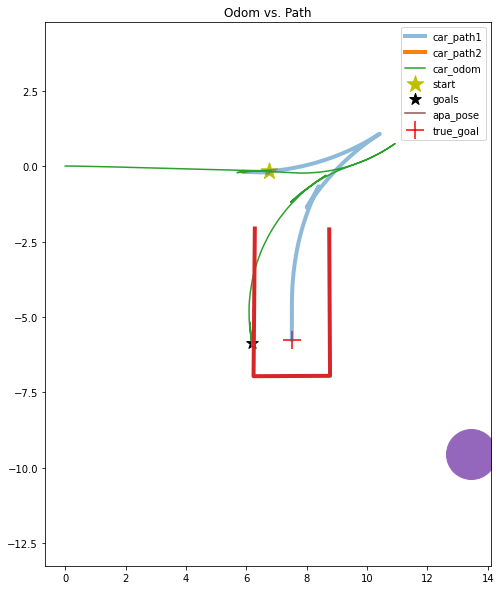

In [59]:
# compare odometry and computed path (Car)
try:
    pillar_x = parking_points_x[0] + 4.7
    pillar_y = parking_points_y[0] - 7.45
except:
    print("no pillar value received")
    
plt.figure(figsize=(8,10))
plt.axis('equal')

# 1. plot computed path
plt.plot(path_carx, path_cary, label="car_path1", linewidth=4, alpha=0.5)
plt.plot(path2_carx, path2_cary, label="car_path2", linewidth=4)
# plt.plot(path3_carx, path3_cary, label="car_path3", linewidth=4)
#plt.plot(path4_carx, path4_cary, label="car_path4", linewidth=4)

# 2. plot odometry
plt.plot(odom_x_car, odom_y_car, label="car_odom")

# 3. plot odom start, goal
plt.scatter(odom_start_x, odom_start_y, label="start", marker='*', color='y', s=300)
# plt.scatter(0.628, -0.5, label="start", marker='*', color='y', s=400)
# plt.scatter(2.04264, -2.22105, label="start", marker='*', color='y', s=400)


plt.scatter(odom_goal_x, odom_goal_y, label="goals", marker='*', color='k', s=150)
print("3. odom_start:\t", odom_start_x, odom_start_y)
print("3. odom_goal:\t", odom_goal_x, odom_goal_y)


# 4. plot parking slot points
plt.plot(parking_points_x, parking_points_y, linewidth=4)

# 5. plot pillars
try:
    plt.plot(pillar_x, pillar_y, marker='.', markersize=100)
except:
    print("cannot plot pillar")

# 6. plot apa car post
plt.plot(apa_x_car, apa_y_car, label="apa_pose")

# 7. plot true goal
# plt.plot(true_goal_x, true_goal_y, label="true_goal", color="r")
plt.scatter(true_goal_x, true_goal_y, label="true_goal", marker='+', color='r', s=300)
print("7. true_goal:\t", true_goal_x, true_goal_y, true_goal_theta)

plt.legend(loc="best")
# plt.xlim(-1,9)
# plt.ylim(-6,10)


plt.title("Odom vs. Path")

plt.show()


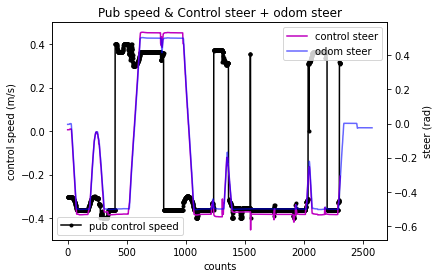

In [60]:
# plot control speed and control steer from PubControl (Car)

fig, ax3 = plt.subplots()

# pub control speed
ln4 = ax3.plot(pub_v_car, 'k.-', label = "pub control speed") # 
# plt.legend(loc="upper left")
plt.legend(loc="lower left")
ax3.set_ylabel("control speed (m/s)")
ax3.set_xlabel("counts")
plt.ylim(-0.5,0.5)

# control steer vs odom steer
ax4 = ax3.twinx()
ln5 = ax4.plot(control_steer_car, 'm', label = "control steer")
ln5 = ax4.plot(odom_phi_car, 'b', label = "odom steer", alpha=0.6)
plt.legend(loc="upper right")
ax4.set_ylabel("steer (rad)")
# plt.xlim(0,2500)
plt.title("Pub speed & Control steer + odom steer")
plt.show()

In [54]:
# plt.plot(pub_car_time, pub_v_car, label="PubControl v")
# # plt.plot(rc_time, apa_rc_speed, label="apa rc v")
# plt.plot(control_car_time, real_car_v, label="Observed v")
# plt.title("Velocity Comparisons")
# plt.legend(loc='upper right',fontsize='x-small')
# # plt.legend(loc='lower left', fontsize='x-small')
# # plt.xlim(12000,26000)
# plt.show()

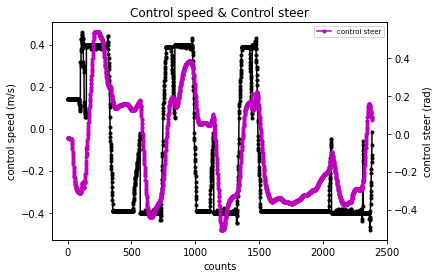

In [55]:
# plot control speed and control steer from ComputeControlValue (Car)

fig, ax3 = plt.subplots()
ln4 = ax3.plot(control_v_car, 'k.-', label = "control speed")
ax3.set_ylabel("control speed (m/s)")
ax3.set_xlabel("counts")
#plt.ylim(0,0.3)

ax4 = ax3.twinx()
ln5 = ax4.plot(control_steer_car, 'm.-', label = "control steer")
ax4.set_ylabel("control steer (rad)")
#plt.xlim(0,400)
plt.title("Control speed & Control steer")
plt.legend(loc='upper right',fontsize='x-small')
plt.show()

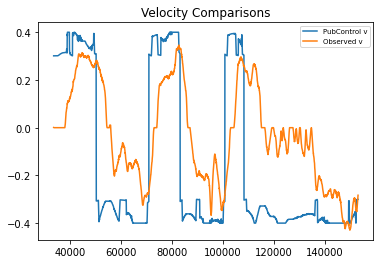

In [56]:
# manually calculate actual velocity

real_car_v = []
for t in control_car_time:
    try:
        i = car_time.index(t)
    except ValueError:
        real_car_v.append(real_car_v[len(real_car_v)-1])
        continue
    prev_i = i - 10
    dt = car_time[i] - car_time[prev_i]
    
    
    cosT = math.cos(odom_theta_car[prev_i])
    sinT = math.sin(odom_theta_car[prev_i])
    dx = odom_x_car[i] - odom_x_car[prev_i]
    dy = odom_y_car[i] - odom_y_car[prev_i]
    dx_copy = dx
    dx = cosT*dx + sinT*dy
    dy = -sinT*dx_copy + cosT*dy
    d = math.sqrt(dx*dx + dy*dy)
    if (dt == 0):
        real_car_v.append(0)
    else:
        if (dx >= 0):
            real_car_v.append(d/dt*1000)
        else:
            real_car_v.append(d/dt*-1000) 

# plot control with actual speed
# plt.plot(control_car_time, control_v_car, label="ComputeControl v")
plt.plot(pub_car_time, pub_v_car, label="PubControl v")
# plt.plot(rc_time, apa_rc_speed, label="apa rc v")
plt.plot(control_car_time, real_car_v, label="Observed v")
plt.title("Velocity Comparisons")
plt.legend(loc='upper right',fontsize='x-small')
# plt.legend(loc='lower left', fontsize='x-small')
# plt.xlim(12000,26000)
plt.show()